# Invert Poisson equation using SOR method
**21 December 2020 by MiniUFO**

---
[TOC]

---

## 1. Introduction
Researches on meteorology and oceanography usually encounter [inversion problems](https://doi.org/10.1017/CBO9780511629570) that need to be solved numerically.  One of the classical inversion problem is to solve for a streamfunction $\psi$ given the vertical component of vorticity $\zeta$ and proper boundary conditions:
>$$
\nabla^2 \psi = \frac{\partial^2 \psi}{\partial x^2} +\frac{\partial^2 \psi}{\partial y^2} =\zeta
$$

Nowadays [`xarray`](http://xarray.pydata.org/en/stable/) becomes a popular data structure commonly used in [Big Data Geoscience](https://pangeo.io/).  Since the whole 4D data, as well as the coordinate information, are all combined into [`xarray`](http://xarray.pydata.org/en/stable/), solving the inversion problem become quite straightforward and the only input would be just one [`xarray.DataArray`](http://xarray.pydata.org/en/stable/) of $\zeta$.  Inversion on the spherical earth, like some meteorological problems, could utilize the spherical harmonics like [windspharm](https://github.com/ajdawson/windspharm), which would be more efficient using FFT than SOR used here.  However, in the case of ocean, SOR method is definitely a better choice in the presence of land/sea mask.

More importantly, this could be generalized into a numerical solver for elliptical equation using [SOR](https://mathworld.wolfram.com/SuccessiveOverrelaxationMethod.html) method, with varying coefficients $A$, $B$ and $C$ as:
>$$
\nabla^2 \psi \equiv \frac{\partial}{\partial x}\left(A\frac{\partial \psi}{\partial x}+B\frac{\partial \psi}{\partial y}\right) +\frac{\partial}{\partial y}\left(B\frac{\partial \psi}{\partial x}+C\frac{\partial \psi}{\partial y}\right) =F
$$

where $AC-B^2>0$ ensures the ellipticness of the equation and convergence of the [SOR](https://mathworld.wolfram.com/SuccessiveOverrelaxationMethod.html) iteration.  Various popular inversion problems in geofluid science will be illustrated as examples.

One problem with SOR is that the speed of iteration using explicit loops will be **e-x-t-r-e-m-e-l-y ... s-l-o-w**!  A very suitable solution here is to use [`numba`](https://numba.pydata.org/).  We may try our best to speed things up using more hardwares (possibly GPU).

---
## 2. Example: Helmholtz decomposition
This is a classical problem in both meteorology and oceanography that a vector flow field can be deomposed into rotational and divergent parts (known as [Helmholtz decomposition](https://en.wikipedia.org/wiki/Helmholtz_decomposition)), where rotational and divergent parts are represented by the streamfunction $\psi$ and velocity potential $\chi$ as:
>$$
\begin{align}
\frac{\partial^2 \psi}{\partial x^2} +\frac{\partial^2 \psi}{\partial y^2} =\frac{\partial v}{\partial x} -\frac{\partial u}{\partial y}=vor \label{Eq1}\tag{1}\\
\frac{\partial^2 \chi}{\partial x^2} +\frac{\partial^2 \chi}{\partial y^2} =\frac{\partial u}{\partial x} +\frac{\partial v}{\partial y}=div \label{Eq2}\tag{2}
\end{align}
$$

Given vorticity (vor) and divergence (div) as the forcing functions respectively in Eqs. ($\ref{Eq1}$) and ($\ref{Eq2}$) (i.e., two Poisson equations), one can invert the streamfunction $\psi$ and velocity potential $\chi$ using [SOR](https://mathworld.wolfram.com/SuccessiveOverrelaxationMethod.html) iteration method.


### 2.1 Atmospheric demonstration
Here is an atmospheric demonstration with no lateral boundaries.  First, we load in vorticity data from a file:

In [1]:
import sys
sys.path.append('../../')
from xgrads.xgrads import open_CtlDataset

ds = open_CtlDataset('D:/SOR.ctl')

vor = ds.vor

print(vor)

<xarray.DataArray 'vor' (time: 31, lat: 73, lon: 144)>
dask.array<reshape, shape=(31, 73, 144), dtype=float32, chunksize=(31, 73, 144), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2008-01-01 2008-01-02 ... 2008-01-31
  * lat      (lat) float32 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    comment:  vorticity
    storage:  99


Inverting the streamfunction, within lat/lon plane but loop over time dimension, is as simple as:

In [2]:
from xinvert.xinvert import invert_Poisson

sf = invert_Poisson(vor, dims=['lat','lon'], BCs=['extend', 'periodic'])

print(sf)

{time: 2008-01-01T00:00:00} loops  369 and tolerance is 9.777046e-07
{time: 2008-01-02T00:00:00} loops  645 and tolerance is 9.860733e-07
{time: 2008-01-03T00:00:00} loops  115 and tolerance is 5.963882e-07
{time: 2008-01-04T00:00:00} loops  824 and tolerance is 9.929594e-07
{time: 2008-01-05T00:00:00} loops  821 and tolerance is 9.961587e-07
{time: 2008-01-06T00:00:00} loops  519 and tolerance is 9.914124e-07
{time: 2008-01-07T00:00:00} loops  539 and tolerance is 9.627416e-07
{time: 2008-01-08T00:00:00} loops  105 and tolerance is 1.879184e-07
{time: 2008-01-09T00:00:00} loops  257 and tolerance is 7.676620e-07
{time: 2008-01-10T00:00:00} loops  239 and tolerance is 8.066450e-07
{time: 2008-01-11T00:00:00} loops  234 and tolerance is 9.910988e-07
{time: 2008-01-12T00:00:00} loops  235 and tolerance is 9.424872e-07
{time: 2008-01-13T00:00:00} loops  265 and tolerance is 9.798478e-07
{time: 2008-01-14T00:00:00} loops   98 and tolerance is 8.401843e-07
{time: 2008-01-15T00:00:00} loops 

Notice that this is a global case, so the zonal boundary condition is periodic.  Meridional extend boundary condition allows streamfunction to variate near the poles.  The result can be visualized as:

C:\ProgramData\Anaconda3\lib\site-packages\proplot\config.py:554: ProPlotWarning: rc setting 'tight' was renamed to subplots.tight in version 0.6.
C:\ProgramData\Anaconda3\lib\site-packages\proplot\config.py:554: ProPlotWarning: rc setting 'geogrid.labels' was renamed to grid.labels in version 0.6.
C:\ProgramData\Anaconda3\lib\site-packages\proplot\config.py:554: ProPlotWarning: rc setting 'geogrid.labelsize' was renamed to grid.labelsize in version 0.6.
C:\ProgramData\Anaconda3\lib\site-packages\proplot\figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super().colorbar(*args, cax=cax, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\cartopy\mpl\geoaxes.py:1841: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  u, v = self.projection.transform_vectors(t, x, y, u, v)
C:\Prog

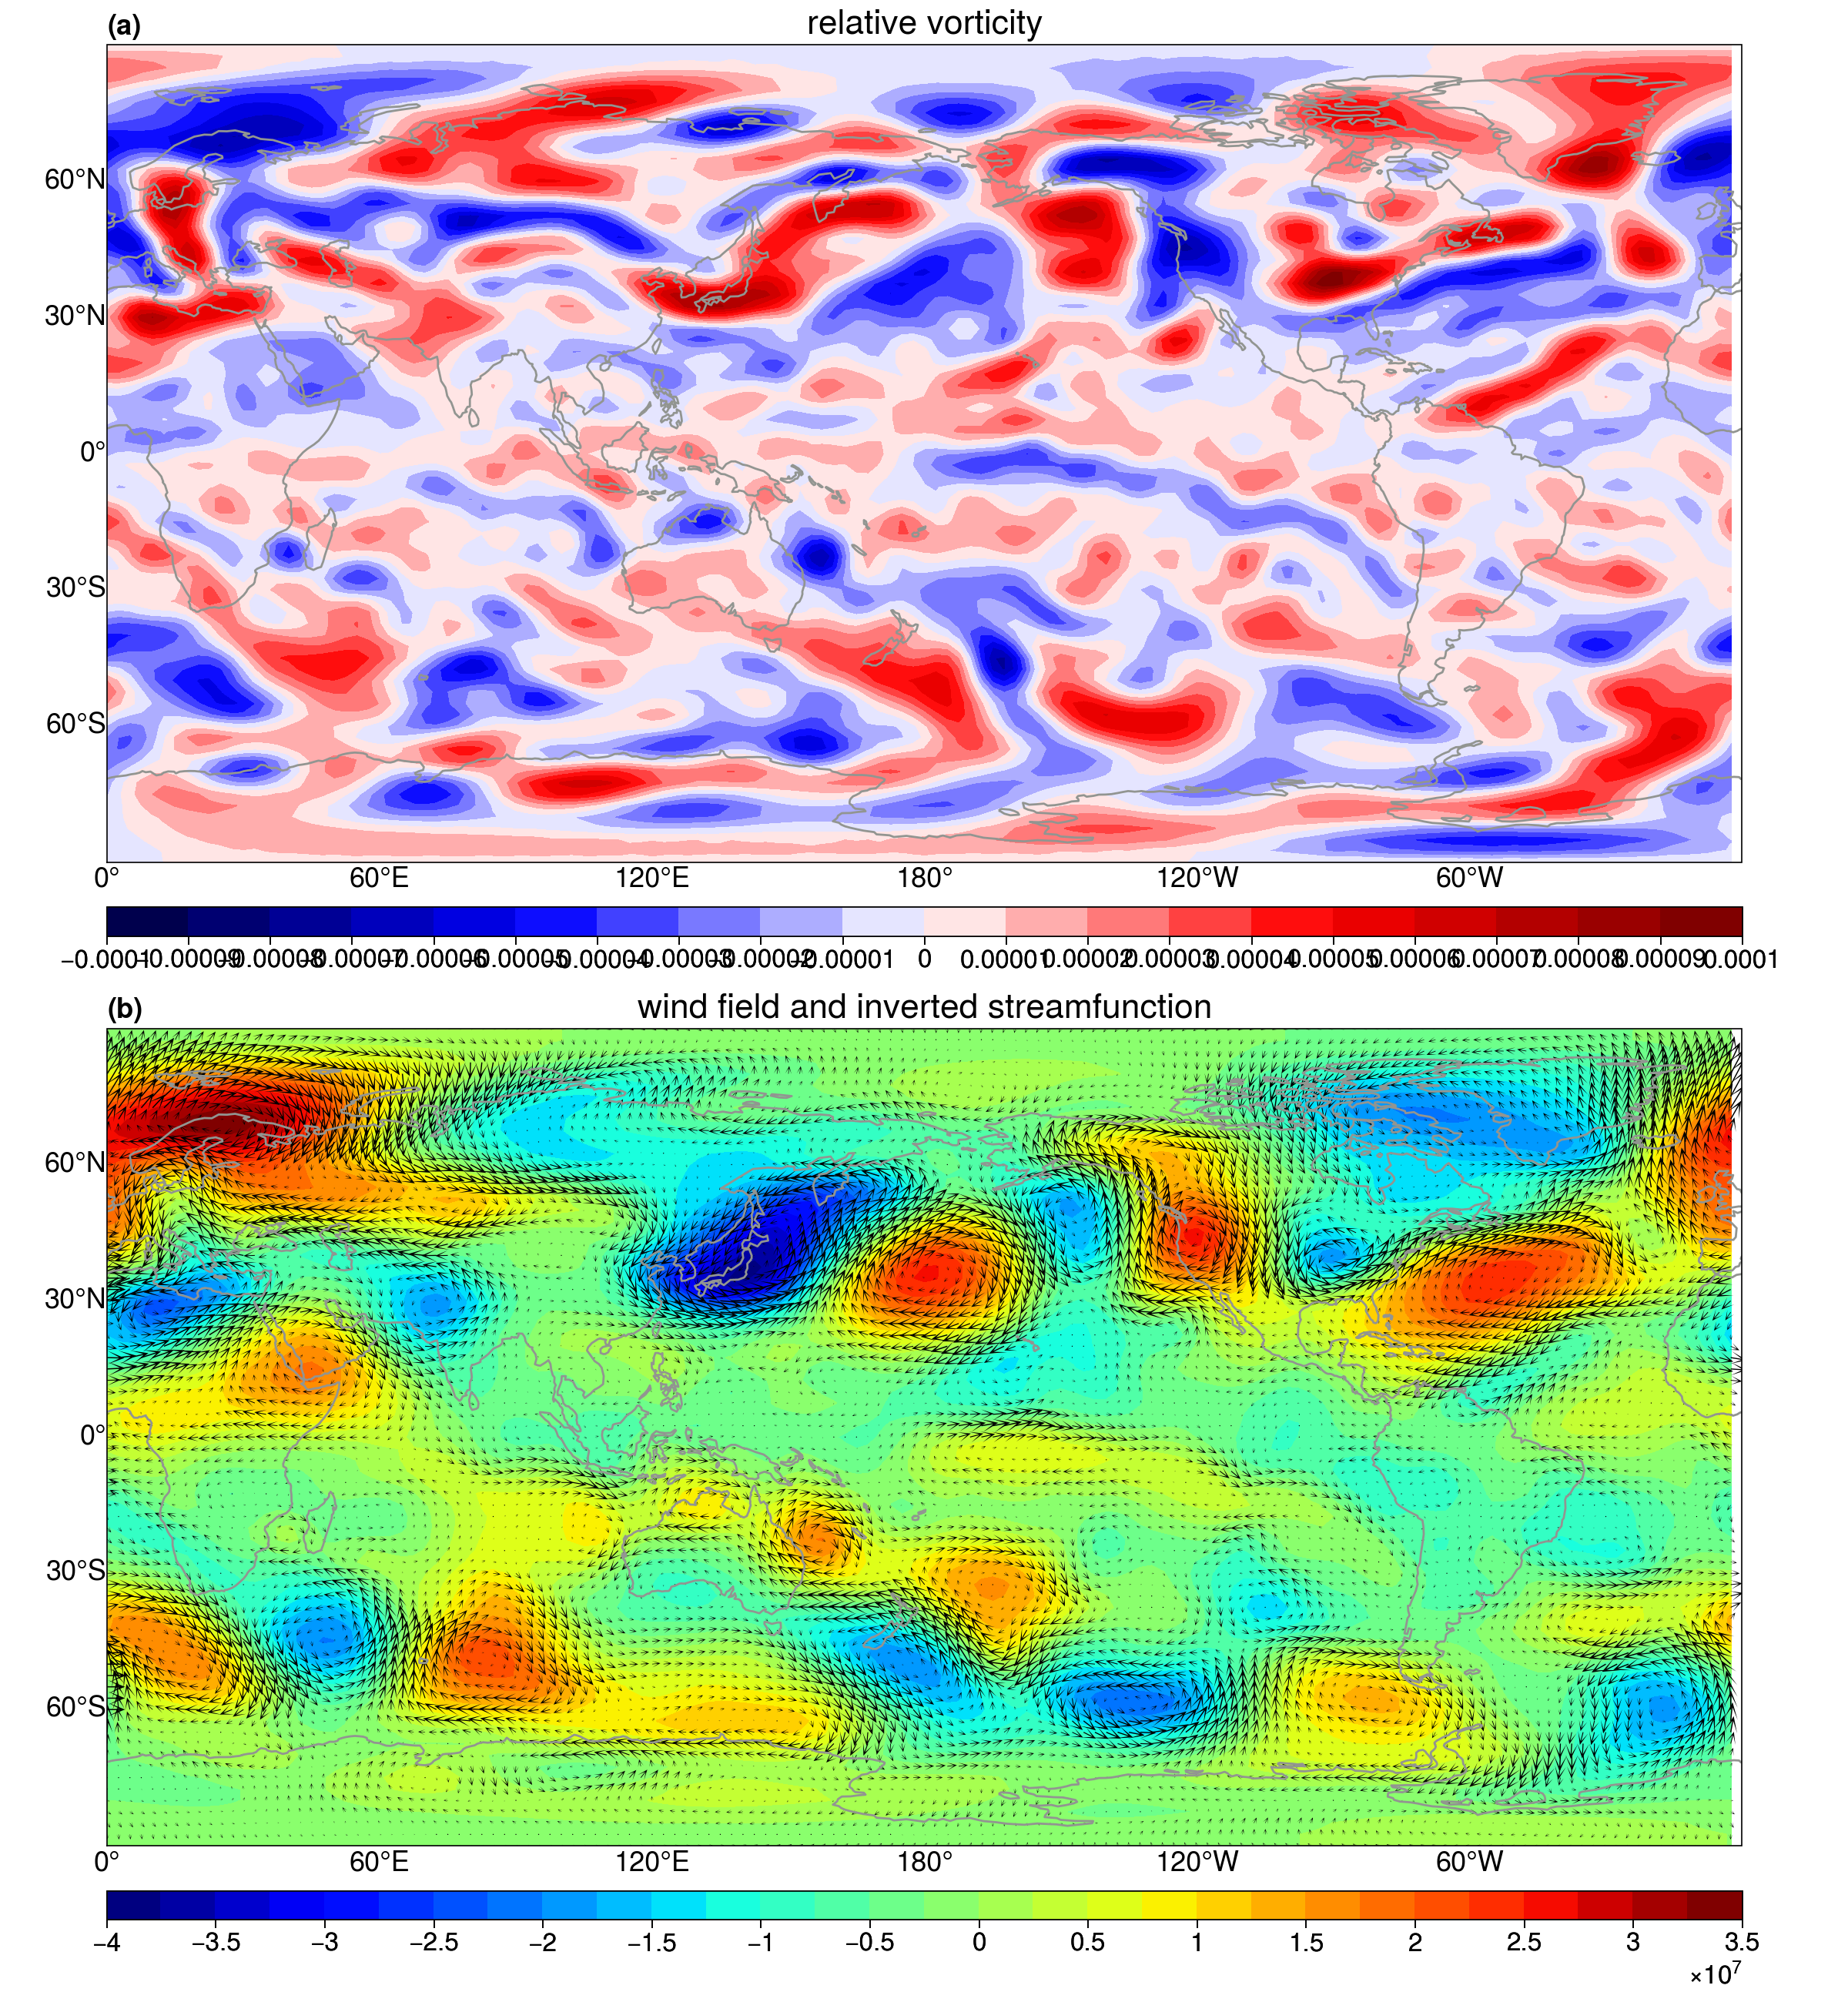

In [3]:
import proplot as pplt
import xarray as xr
import numpy as np

# select the first time step
u = ds.u.where(ds.u!=0)[0].load()
v = ds.v.where(ds.v!=0)[0].load()
m = np.hypot(u, v)

fig, axes = pplt.subplots(nrows=2, ncols=1, figsize=(12, 13), sharex=3, sharey=3,
                          proj=pplt.Proj('cyl', lon_0=180))

fontsize = 16

axes.format(abc=True, abcloc='l', abcstyle='(a)', coast=True,
            lonlines=60, latlines=30, lonlabels='b', latlabels='l',
            grid=False, labels=False)

ax = axes[0]
p = ax.contourf(u.lon, u.lat, vor[0], cmap='seismic',
                levels=np.linspace(-1e-4, 1e-4, 21))
ax.set_title('relative vorticity', fontsize=fontsize)
ax.colorbar(p, loc='b', label='', ticks=1e-5, length=0.895)

ax = axes[1]
p = ax.contourf(u.lon, u.lat, sf[0], levels=31, cmap='jet')
ax.quiver(u.lon.values, u.lat.values, u.values, v.values,
              width=0.0007, headwidth=12., headlength=15.)
              # headwidth=1, headlength=3, width=0.002)
ax.set_title('wind field and inverted streamfunction', fontsize=fontsize)
ax.colorbar(p, loc='b', label='', length=0.895)

### 2.2 Oceanic demonstration
Here is a oceanic demonstration with complex lateral boundaries of land/sea.  Read in data from MITgcm model output and then invert similarly as:

In [4]:
import xarray as xr
from xinvert.xinvert import invert_Poisson


ds = xr.open_dataset('D:/mitgcm.nc')

vor = ds.vor[0] # select the first time step

print(vor)

sf = invert_Poisson(vor, dims=['YG','XG'], BCs=['extend', 'periodic'],
                    undef=0, tolerance=1e-9)

print(sf)

<xarray.DataArray 'vor' (YG: 720, XG: 1440)>
[1036800 values with dtype=float32]
Coordinates:
  * XG       (XG) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
    iter     int32 ...
    time     timedelta64[ns] 00:00:00
  * YG       (YG) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
{} loops 1472 and tolerance is 5.334622e-12
<xarray.DataArray 'inverted' (YG: 720, XG: 1440)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * XG       (XG) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
    iter     int32 0
    time     timedelta64[ns] 00:00:00
  * YG       (YG) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88


The result can be visualized as:

C:\ProgramData\Anaconda3\lib\site-packages\proplot\figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super().colorbar(*args, cax=cax, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\proplot\figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super().colorbar(*args, cax=cax, **kwargs)


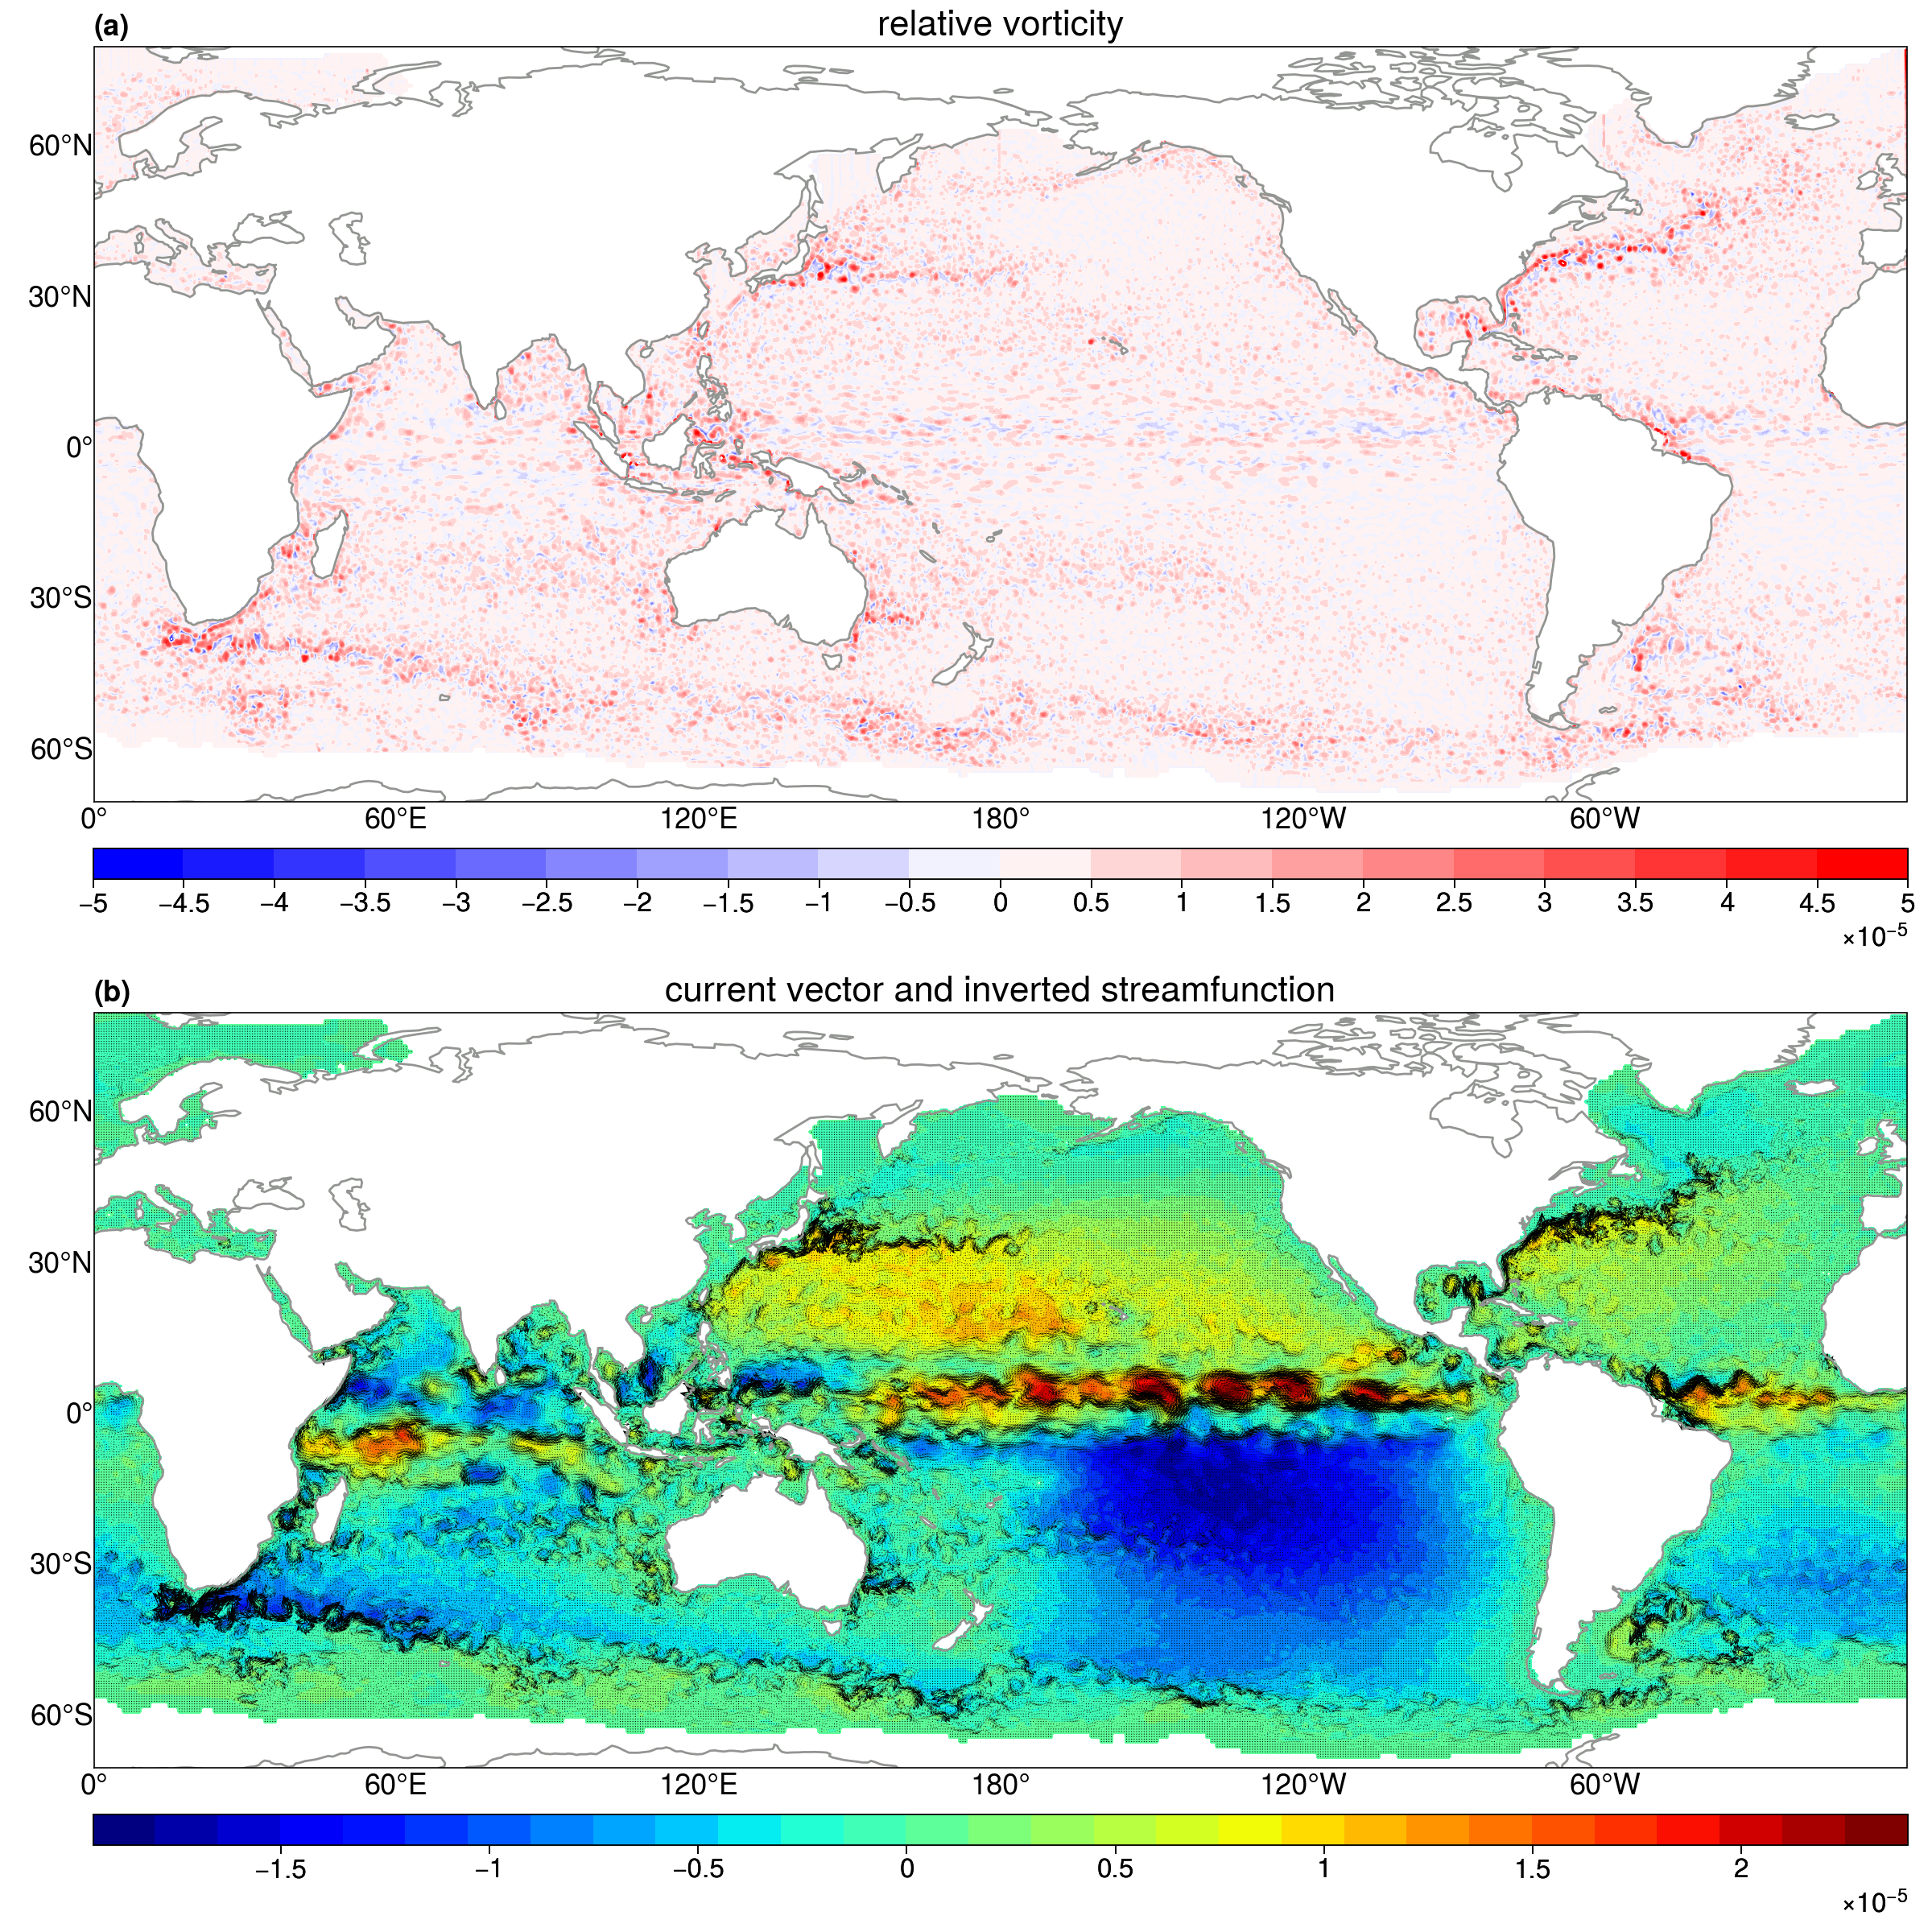

In [5]:
import proplot as pplt
import xarray as xr

# deal with staggered velocity data
u = ds.UVEL[0]
v = ds.VVEL[0].rename({'YG':'YC', 'XC':'XG'}).interp_like(u)
m = np.hypot(u, v)

fig, axes = pplt.subplots(nrows=2, ncols=1, figsize=(12, 12), sharex=3, sharey=3,
                          proj=pplt.Proj('cyl', lon_0=180))

fontsize = 16

u = u.where(u!=0)
v = v.where(v!=0)
sf = sf.where(sf!=0)

axes.format(abc=True, abcloc='l', abcstyle='(a)', coast=True,
            lonlines=60, latlines=30, lonlabels='b', latlabels='l',
            grid=False, labels=False)

ax = axes[0]
p = ax.contourf(u.XG, u.YC, vor.where(vor!=0), cmap='bwr',
                levels=np.linspace(-5e-5, 5e-5, 21))
ax.set_title('relative vorticity', fontsize=fontsize)
ax.set_ylim([-70, 80])
ax.set_xlim([-180, 180])
ax.colorbar(p, loc='b', label='', ticks=5e-6, length=0.985)

ax = axes[1]
skip = 2
p = ax.contourf(u.XG, u.YC, sf, levels=31, cmap='jet')
ax.quiver(u.XG.values[::skip], u.YC.values[::skip],
              u.values[::skip,::skip], v.values[::skip,::skip],
              width=0.0006, headwidth=12., headlength=15.)
ax.set_title('current vector and inverted streamfunction', fontsize=fontsize)
ax.set_ylim([-70, 80])
ax.set_xlim([-180, 180])
ax.colorbar(p, loc='b', label='', ticks=5e-6, length=0.985)

### 3.3 Animate the convergence of iteration
It is interesting to see the whole convergence process of SOR iteration as:

In [6]:
from xinvert.xinvert import invert_Poisson_animated

ds = open_CtlDataset('D:/SOR.ctl')

vor = ds.vor[0]
div = ds.div[0]

sf = invert_Poisson_animated(vor, BCs=['extend', 'periodic'],
                             loop_per_frame=1, max_loop=40)
vp = invert_Poisson_animated(div, BCs=['extend', 'periodic'],
                             loop_per_frame=1, max_loop=40, printInfo=False)

print(sf)

loops    1 and tolerance is 6.154371e-01
loops    1 and tolerance is 1.738605e-01
loops    1 and tolerance is 7.720770e-02
loops    1 and tolerance is 3.761353e-02
loops    1 and tolerance is 2.087248e-02
loops    1 and tolerance is 7.618484e-03
loops    1 and tolerance is 1.222605e-03
loops    1 and tolerance is 3.880171e-03
loops    1 and tolerance is 4.680047e-03
loops    1 and tolerance is 6.655481e-03
loops    1 and tolerance is 7.996463e-03
loops    1 and tolerance is 7.598334e-03
loops    1 and tolerance is 5.482862e-03
loops    1 and tolerance is 4.040390e-03
loops    1 and tolerance is 2.623214e-03
loops    1 and tolerance is 1.459028e-03
loops    1 and tolerance is 7.380526e-04
loops    1 and tolerance is 1.918272e-04
loops    1 and tolerance is 8.255552e-04
loops    1 and tolerance is 1.109935e-03
loops    1 and tolerance is 8.597363e-04
loops    1 and tolerance is 5.276580e-04
loops    1 and tolerance is 1.229007e-04
loops    1 and tolerance is 1.084025e-03
loops    1 and t

The iteration dimension is added to indicate how many iterations is used to reach the current state.  This is also the dimension that one may animate over using animation-making tools such as [xmovie](https://github.com/jbusecke/xmovie).  Here we only show the result as:

![animate plot](https://raw.githubusercontent.com/miniufo/xinvert/master/pics/animateConverge.gif)

---

### References
[https://dask.org/](https://dask.org/)

[http://xarray.pydata.org/en/stable/](http://xarray.pydata.org/en/stable/)